In [293]:
import re
import cv2
import pytesseract
from matplotlib import pyplot as plt
import numpy as np

def skeleton(file: str):
    img = cv2.imread(file, 0)
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    
    ret, img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
    
    while(not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
    
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel

def rotate_image(image, rotation: int):
    height, width = image.shape[:2]
    center_x, center_y = (width/2, height/2)
    rotation = cv2.getRotationMatrix2D((center_x, center_y), rotation, 1.0)
    rotated_image = cv2.warpAffine(image, rotation, (width, height))
    return rotated_image

def add_contour(image, dilation):
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

def get_data(text):
    name_re = re.compile(r"NO[MW]BRE.*\n([^ \n]*).*\n(.*)\n(.*)\n")
    name_matches = name_re.findall(text)
    curp_re = re.compile(r"C?U?[AR][PE].*\n?([0-9A-Za-z]{18})")
    curp_matches = curp_re.findall(text)
    birth_date_re = re.compile(r"\d{2}/\d{2}/\d{4}")
    birth_date = birth_date_re.findall(text)
    expiration_re = re.compile(r"(EMISION|VI[CG]ENCIA[^\d]*)(\d{4})")
    expiration_match = expiration_re.findall(text)
    names = name_matches[0] if name_matches else []
    expiration = expiration_match[0] if expiration_match else []
    return {
        "paterno": names[0] if len(names) > 0 else "",
        "materno": names[1] if len(names) > 1 else "",
        "nombre": names[2] if len(names) > 2 else "",
        "curp": curp_matches[0] if curp_matches else "",
        "nacimiento": birth_date[0] if birth_date else [],
        "expiracion": expiration[1] if len(expiration) > 1 else None,
        "esta_expirada": int(expiration[1]) < 2022 if len(expiration) > 1 else None,
    }

def detect_raw_text(image_path, image):
    recognized_text_path = image_path[:image_path.rfind(".")] + "-recognized.txt"
    with open(recognized_text_path, "w") as file:
        text = pytesseract.image_to_string(image)
        file.write(text)
    return get_data(text)

def detect_text(image_path, img, dilation):
    pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'
    recognized_boxes_path = image_path[:image_path.rfind(".")] + "-boxes" + image_path[image_path.rfind("."):]
    recognized_text_path = image_path[:image_path.rfind(".")] + "-recognized.txt"
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im2 = img.copy()
    with open(recognized_text_path, "w+") as file:
        file.write("")

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cropped = im2[y:y + h, x:x + w]
        with open(recognized_text_path, "a") as file:
            # Apply OCR on the cropped image
            text = pytesseract.image_to_string(cropped).upper()
            file.write(text)
    cv2.imwrite(recognized_boxes_path, im2)
    with open(recognized_text_path) as file:
        return get_data(file.read())

In [357]:
def load_image_1(file = "./images/ine_01.png", kernel = (3, 3)):
    img = cv2.imread(file)
    img = rotate_image(img, -7)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = thresh1
    dilation = cv2.dilate(dilation, rect_kernel, iterations = 1)
    dilation = cv2.erode(dilation, rect_kernel, iterations = 1)
    # dilation = cv2.GaussianBlur(dilation, ksize=(0, 0), sigmaX=1)
    return file, img, dilation

def load_image_2(file = "./images/ine_02.png", kernel = (3, 3)):
    img = cv2.imread(file)
    img = rotate_image(img, 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = thresh1
    dilation = cv2.dilate(dilation, rect_kernel, iterations = 1)
    dilation = cv2.erode(dilation, rect_kernel, iterations = 1)
    # dilation = cv2.GaussianBlur(dilation, ksize=(0, 0), sigmaX=1)
    return file, img, dilation

def load_image_3(file = "./images/ine_03.png", kernel = (3, 3)):
    img = cv2.imread(file)
    img = rotate_image(img, -3)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = thresh1
    dilation = cv2.dilate(dilation, rect_kernel, iterations = 1)
    # dilation = cv2.erode(dilation, rect_kernel, iterations = 1)
    dilation = cv2.GaussianBlur(dilation, ksize=(1, 1), sigmaX=4)
    return file, img, dilation

def load_image_4(file = "./images/ine_04.png", kernel = (3, 3)):
    img = cv2.imread(file)
    img = rotate_image(img, 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    ret, thresh1 = cv2.threshold(gray, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilate = thresh1
    dilation = cv2.dilate(dilate, rect_kernel, iterations=1)
    dilation = cv2.GaussianBlur(dilation, ksize=(1, 1), sigmaX=2)
    dilation = cv2.addWeighted(dilation, 1.5, dilation, -0.5, 0)
    return file, img, dilation

def load_image_5(file = "./images/ine_05.png", kernel = (10, 10)):
    img = cv2.imread(file)
    scale_percent = 20
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    ret, thresh1 = cv2.threshold(gray, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)
    return file, img, dilation

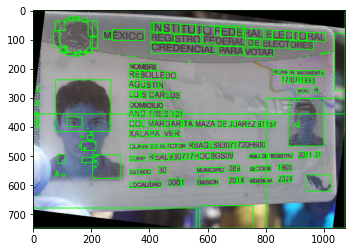

In [358]:
path, image, dilation = load_image_1()
add_contour(image, dilation)
plt.imshow(dilation, cmap="gray")
plt.imshow(image)

In [253]:
path, image, dilation = load_image_1()
detect_text(path, image, dilation)

{'paterno': 'REBOLLEDO',
 'materno': 'AGUSTIN _',
 'nombre': 'LUIS CARLOS',
 'curp': 'REAL930717HOCBGS09',
 'nacimiento': '17/07/1993',
 'expiracion': [],
 'esta_expirada': None}

In [291]:
path, image, dilation = load_image_2()
detect_text(path, image, dilation)

{'paterno': 'GOMEZ',
 'materno': 'VELAZQUEZ',
 'nombre': 'MARGARITA',
 'curp': '',
 'nacimiento': '05/07/1980',
 'expiracion': '2018',
 'esta_expirada': True}

In [294]:
path, image, dilation = load_image_3()
detect_text(path, image, dilation)

{'paterno': 'GOMEZ',
 'materno': 'VELAZQUEZ',
 'nombre': 'MARGARITA',
 'curp': 'GOVM800705MCLMLRO1',
 'nacimiento': '05/07/1980',
 'expiracion': None,
 'esta_expirada': None}

In [315]:
path, image, dilation = load_image_4()
detect_text(path, image, dilation)

{'paterno': '',
 'materno': '',
 'nombre': '',
 'curp': 'PENE660720HDFNTNO3',
 'nacimiento': [],
 'expiracion': None,
 'esta_expirada': None}

In [344]:
import csv
import numpy as np
import matplotlib.pyplot as plt

CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZÑ0123456789"
#Total characters 37
CHARACTER, ITALIC, HEIGHT, WIDTH = 2, 4, 10, 11

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def read_font(font, x, y):
    with open(font, "r") as file:
        reader = csv.reader(file)
        header = next(reader)
        for row in reader:
            height, width = int(row[HEIGHT]), int(row[WIDTH])
            character, italic = chr(int(row[CHARACTER])), bool(int(row[ITALIC]))
            if character in CHARACTERS and not italic:
                letter = np.array(row[12:], dtype=np.int64).reshape(height, width, 1)
                x.append(letter)
                y.append(CHARACTERS.find(character))

def load_dataset(font_1="./fonts/ARIAL.csv", font_2="./fonts/SANSSERIF.csv"):
    x, y = [], []
    read_font(font_1, x, y)
    read_font(font_2, x, y)
    x, y = np.array(x), np.array(y)
    x, y = unison_shuffled_copies(x, y)
    max_length = int(0.9*len(x))
    return x[:max_length], y[:max_length], x[max_length:], y[max_length:]

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def get_prediction(element):
    prediction = model.predict(np.array([element]))[0]
    index = np.argmax(prediction)
    probability = prediction[index]
    character = CHARACTERS[index]
    return character, probability

def show_prediction(element):
    plt.imshow(element, cmap="gray")
    return get_prediction(element)

def try_index(x, y, index):
    char, prob = show_prediction(x[index])
    print(f"predicted={char}, {prob=}, expected={CHARACTERS[y[index]]}")

In [317]:
x_train, y_train, x_validation, y_validation = load_dataset()
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(7725, 20, 20, 1)
(859, 20, 20, 1)
(7725,)
(859,)


In [319]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

class StopOnPoint(Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True

model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
  MaxPooling2D(2, 2),
  Conv2D(16, (3, 3), activation='relu'),
  MaxPooling2D(2,2),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(37, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 128)               1

2022-06-17 00:23:44.612434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [320]:
training_result = model.fit(
    x_train, y_train, epochs=100, 
    validation_data=(x_validation, y_validation),
    callbacks=[StopOnPoint(0.99)]
)

Epoch 1/100
242/242 [==============================] - 3s 10ms/step - loss: 9.6046 - accuracy: 0.3172 - val_loss: 1.9372 - val_accuracy: 0.7171
Epoch 2/100
242/242 [==============================] - 3s 10ms/step - loss: 2.1152 - accuracy: 0.6594 - val_loss: 1.0067 - val_accuracy: 0.8405
Epoch 3/100
242/242 [==============================] - 2s 9ms/step - loss: 1.2229 - accuracy: 0.7895 - val_loss: 0.6499 - val_accuracy: 0.8871
Epoch 4/100
242/242 [==============================] - 2s 9ms/step - loss: 0.8725 - accuracy: 0.8414 - val_loss: 0.4759 - val_accuracy: 0.9080
Epoch 5/100
242/242 [==============================] - 2s 10ms/step - loss: 0.6569 - accuracy: 0.8690 - val_loss: 0.3659 - val_accuracy: 0.9197
Epoch 6/100
242/242 [==============================] - 2s 9ms/step - loss: 0.5106 - accuracy: 0.8904 - val_loss: 0.2706 - val_accuracy: 0.9371
Epoch 7/100
242/242 [==============================] - 2s 9ms/step - loss: 0.4121 - accuracy: 0.9058 - val_loss: 0.2196 - val_accuracy: 0.9

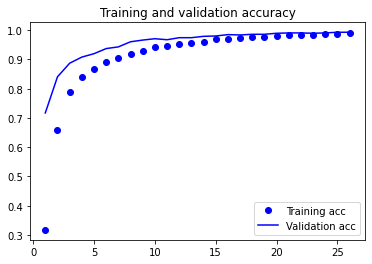

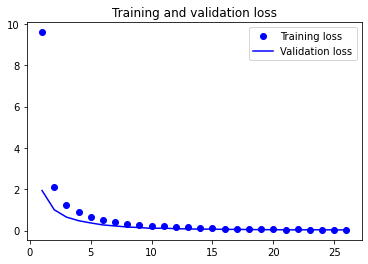

In [321]:
plot_history(training_result)

1/1 [==============================] - 0s 105ms/step
predicted=2, prob=1.0, expected=2


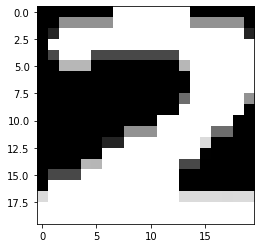

In [322]:
try_index(x_train, y_train, np.random.randint(len(x_train)))

In [347]:
def detect_text_with_model(image_path, img, dilation):
    pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'
    recognized_boxes_path = image_path[:image_path.rfind(".")] + "-boxes-nn" + image_path[image_path.rfind("."):]
    recognized_text_path = image_path[:image_path.rfind(".")] + "-recognized-nn.txt"
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im2 = img.copy()
    with open(recognized_text_path, "w+") as file:
        file.write("")

    result = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cropped = im2[y:y + 20, x:x + 20]
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        section = np.array(gray).reshape(20, 20, 1)
        if section.shape != (20, 20, 1):
            continue
        prediction = get_prediction(section)[0]
        with open(recognized_text_path, "a") as file:
            file.write(prediction)
        character = CHARACTERS[np.argmax(prediction)]
        text = pytesseract.image_to_string(cropped).upper()
        result.append((character, text))
    cv2.imwrite(recognized_boxes_path, im2)
    with open(recognized_text_path) as file:
        return get_data(file.read())

In [359]:
path, image, dilation = load_image_1()
result = detect_text_with_model(path, image, dilation)

1/1 [==============================] - 0s 16ms/step
